# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, functions
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import feature
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.feature import VectorAssembler, MinMaxScaler


In [3]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify - Project").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [5]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [6]:
df.count()

286500

In [7]:
len(df.columns)

18

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [10]:
df.toPandas().skew(axis=0, skipna=True)

itemInSession    2.480746
length           5.338281
registration    -1.586332
sessionId        0.217484
status           2.868533
ts               0.062416
dtype: float64

In [11]:
df.toPandas().kurt(axis=0, skipna=True)

itemInSession     9.961081
length           85.489538
registration      3.205200
sessionId        -1.309083
status            6.573906
ts               -1.172516
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6302228f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f62a2e98240>]], dtype=object)

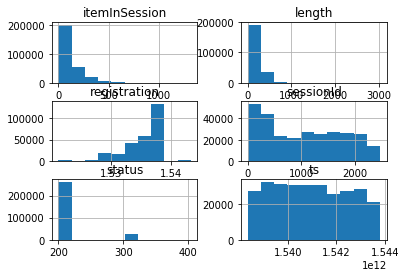

In [12]:
df.toPandas().hist()

In [13]:
df.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [14]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [15]:
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [16]:
session_ids = df.toPandas()['sessionId'].unique().tolist()
for id in session_ids:
    if id == '':
        print("Empty session Id")
    elif id is None:
        print("Session Id is None")

There are no empty nor None session ids

In [17]:
df_valid = df.dropna(how="any", subset=["userId", "sessionId"])
df_valid = df_valid.filter(df_valid["userId"] != "")

df_pandas = df_valid.toPandas()

In [18]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [19]:
#Getting a list of churned users.

churned_users = list(df_pandas[df_pandas['page'] == 'Submit Downgrade']['userId'].unique())
churned_users.extend(list(df_pandas[df_pandas['page'] == 'Cancellation Confirmation']['userId'].unique()))
churned_users = list(set(churned_users))

In [20]:
#Constructing dataframe to visualize churn with respect to gender
unique_userIds = df_pandas['userId'].unique().tolist()
gender = []
for userId in unique_userIds:
    gender.append(df_pandas[df_pandas['userId'] == userId]['gender'].iloc[0])
df_gender = pd.DataFrame({'userId': unique_userIds, 'gender': gender})
df_gender['churn'] = df_gender['userId'].apply(lambda x: 1 if x in churned_users else 0)

In [21]:
df_gender.head()

,userId,gender,churn
0,30,M,1
1,9,M,1
2,74,F,1
3,54,F,1
4,4,M,0


In [22]:
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

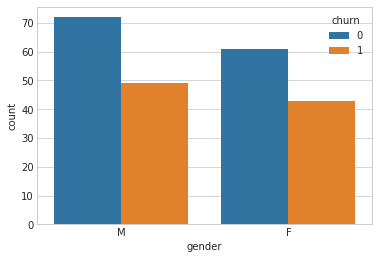

In [23]:
sns.countplot(x = "gender", hue="churn", data=df_gender)

In [24]:
level = []
for userId in unique_userIds:
    level.append(df_pandas[df_pandas['userId'] == userId]['level'].iloc[0])
df_level = pd.DataFrame({'userId': unique_userIds, 'level': level})
df_level['churn'] = df_gender['userId'].apply(lambda x: 1 if x in churned_users else 0)
df_level.head()

,userId,level,churn
0,30,paid,1
1,9,free,1
2,74,free,1
3,54,paid,1
4,4,free,0


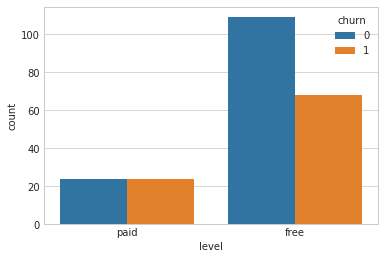

In [25]:
sns.countplot(x="level", hue="churn", data=df_level)

In [26]:
df_valid.createOrReplaceTempView("sparkify_table")

### Define Churn

Churn is defined when user downgrade or cancellation confirmation

In [27]:
downgrade_event = udf(lambda x: 1 if (x == "Submit Downgrade" or x == "Cancellation Confirmation") else 0, IntegerType())

In [28]:
a = spark.sql("SELECT userId, CASE when page = 'Submit Downgrade' or page = 'Cancellation Confirmation' THEN 1 END as churn FROM sparkify_table")

In [29]:
a.createOrReplaceTempView('churn_table')
b = spark.sql("SELECT * FROM churn_table WHERE churn is not null")
b.createOrReplaceTempView('churn_users')

In [30]:
spark.sql("SELECT * FROM churn_users").show()

+------+-----+
|userId|churn|
+------+-----+
|   131|    1|
|    38|    1|
|   141|    1|
|    18|    1|
|    30|    1|
|    20|    1|
|    32|    1|
|    12|    1|
|    11|    1|
|    61|    1|
|    81|    1|
|   125|    1|
|    85|    1|
|   140|    1|
|   105|    1|
|    17|    1|
|    35|    1|
|   143|    1|
|    54|    1|
|    77|    1|
+------+-----+
only showing top 20 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Average number of Songs per session for each user

In [31]:
number_sessions = spark.sql("SELECT userId, avg(count) as average FROM (SELECT userId, count(*) as count FROM sparkify_table GROUP BY sessionId, userId) GROUP BY userId")

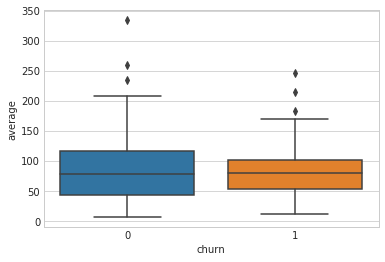

In [32]:
pd_number_sessions = number_sessions.toPandas()
pd_number_sessions['churn'] = pd_number_sessions['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="average", data=pd_number_sessions)

From the above graph we can see that users who downgrade their subscription had a fewer number of songs per session.

In [33]:
# Thumbs up per user

thumbs_up = spark.sql("SELECT userId, COUNT(*) as count_thumbs_up FROM sparkify_table WHERE page = 'Thumbs Up' GROUP BY userId")

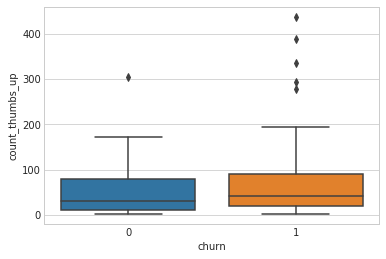

In [34]:
pd_thumbs_up = thumbs_up.toPandas()
pd_thumbs_up['churn'] = pd_thumbs_up['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_thumbs_up", data=pd_thumbs_up)

In [35]:
#thumbs down

thumbs_down = spark.sql("SELECT userId, count(*) as count_thumbs_down FROM sparkify_table where page = 'Thumbs Down' group by userId")

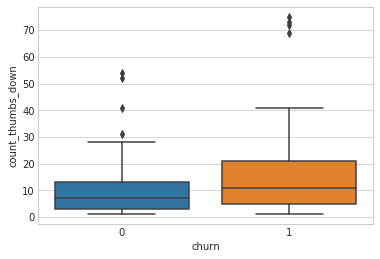

In [36]:
pd_thumbs_down = thumbs_down.toPandas()
pd_thumbs_down['churn'] = pd_thumbs_down['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_thumbs_down", data=pd_thumbs_down)

From the above graphs we can see that users downgrade wether they had more thumbs down or thumbs up.

In [37]:
#number of errors per user

errors = spark.sql("SELECT userId, count(*) as count_errors FROM sparkify_table where page = 'Error' group by userId")

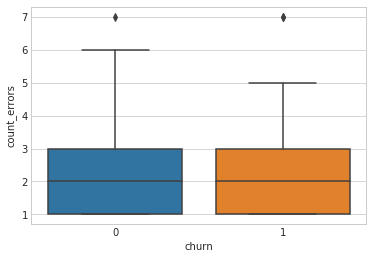

In [38]:
pd_errors_user = errors.toPandas()
pd_errors_user['churn'] = pd_errors_user['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_errors", data=pd_errors_user)

We can see from the above graph that on average, both kind of users had the same number of errors.

In [39]:
#number of add to playlist per user

add_to_playlist = spark.sql("SELECT userId, count(*) as count_add_to_playlist FROM sparkify_table where page = 'Add to Playlist' group by userId")

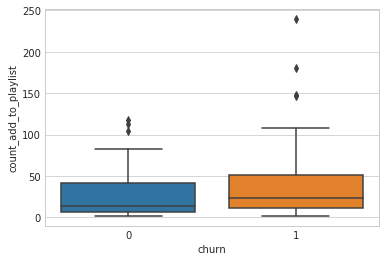

In [40]:
pd_add_playlist = add_to_playlist.toPandas()
pd_add_playlist['churn'] = pd_add_playlist['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_add_to_playlist", data=pd_add_playlist)

We can see we have similar distribution of users for add to playlist events.

In [41]:
#Total songs played per user

total_songs = spark.sql("SELECT userId, COUNT(*) as count_songs FROM sparkify_table GROUP BY userId")

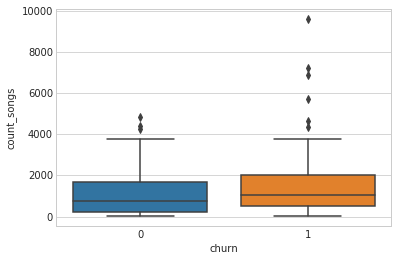

In [42]:
pd_total_songs = total_songs.toPandas()
pd_total_songs['churn'] = pd_total_songs['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_songs", data=pd_total_songs)

From the above graph we can see that churned users played more songs.

In [43]:
# Number of add friends events per user

add_to_friends = spark.sql("SELECT userId, count(*) as count_add_friends FROM sparkify_table where page = 'Add Friend' group by userId")

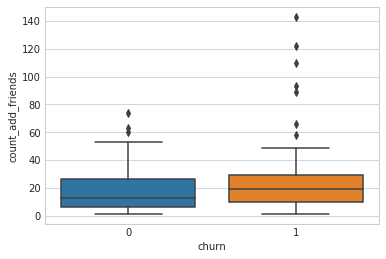

In [44]:
pd_add_friends = add_to_friends.toPandas()
pd_add_friends['churn'] = pd_add_friends['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_add_friends", data=pd_add_friends)

We can observe from the above graph that on average, churned users added more friends.

In [45]:
#Joining DataFrames to construct a unified dataset to be fed into models

df1 = thumbs_down.join(thumbs_up, thumbs_down.userId == thumbs_up.userId).drop(thumbs_up.userId)
df2 = df1.join(errors, errors.userId == df1.userId).drop(errors.userId)
df3 = df2.join(add_to_playlist, add_to_playlist.userId == df2.userId).drop(add_to_playlist.userId)
df4 = df3.join(add_to_friends, add_to_friends.userId == df3.userId).drop(add_to_friends.userId)
df5 = df4.join(total_songs, total_songs.userId == df4.userId).drop(total_songs.userId)
df6 = df5.join(number_sessions, number_sessions.userId == df5.userId).drop(number_sessions.userId)

In [46]:
df7 = df6.join(b, b.userId == df6.userId, "left_outer").drop(b.userId)

In [47]:
df7.createOrReplaceTempView('temp_table')
df_processed = spark.sql("select userId, count_thumbs_down, count_thumbs_up, count_errors, count_add_to_playlist, count_add_friends, count_songs, average, CASE when churn is null then 0 else 1 END as label from temp_table")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Our model is built on the following algorithms:
1. Logistic Regression
2. Random Forest Classifier
3. Gradient Boosting Trees

We split our dataset into 90% training and 10% testing. We use grid search to find the best hyperparameters for our models.


In [48]:
train, test = df_processed.randomSplit([0.9, 0.1], seed=42)

In [49]:
df_processed.columns

input_cols = ['count_thumbs_up', 'count_thumbs_down', 'count_errors', 'count_add_to_playlist', 'count_add_friends', 'count_songs', 'average']

Vassembler = VectorAssembler(inputCols = input_cols, outputCol="features")
scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")


## Logistic Regression


In [52]:
model1 = LogisticRegression(labelCol="label", featuresCol="scaled_features", maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline_model1 = Pipeline(stages=[Vassembler, scalar, model1])

paramGrid = ParamGridBuilder().addGrid(model1.regParam, [0.0,0.1]).build()

crossval_model1 = CrossValidator(estimator=pipeline_model1,
                                          estimatorParamMaps=paramGrid,
                                          evaluator=MulticlassClassificationEvaluator(),
                                          numFolds=3)

crossValModel1 = crossval_model1.fit(train)
crossValModel1.avgMetrics

results_model1 = crossValModel1.transform(test)
print("Logistic Regression Model Accuracy: ", results_model1.filter(results_model1.label == results_model1.prediction).count()/results_model1.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_model1)
print("Logistic Regression Model score: ", score)


Logistic Regression Model Accuracy:  0.7
Logistic Regression Model score:  0.7199999999999999


### Random Forest Classifier

In [59]:
model2 = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
pipeline_model2 = Pipeline(stages=[Vassembler, scalar, model2])

paramGrid = ParamGridBuilder().addGrid(model2.numTrees, [5, 10]).build()

crossval_model2 = CrossValidator(estimator=pipeline_model2, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(), numFolds=3)

crossValModel2 = crossval_model2.fit(train)
crossValModel2.avgMetrics

results_model2 = crossValModel2.transform(test)
print("Random Forest Classifier Model Accuracy: ", results_model2.filter(results_model2.label == results_model2.prediction).count()/ results_model2.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_model2)
print("Random Forest Classifoer Model Score: ", score)

Random Forest Classifier Model Accuracy:  1.0
Random Forest Classifoer Model Score:  1.0


In [57]:
print("The best value for number of trees is: ", crossValModel2.bestModel.stages[-1]._java_obj.parent().getNumTrees())

The best value for number of trees is:  10


### Gradient Boosting Tree Classifier


In [58]:
model3 = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)

pipeline_model3 = Pipeline(stages=[Vassembler, scalar, model3])
paramGrid = ParamGridBuilder().addGrid(model3.maxIter, [5, 10]).build()

crossval_model3 = CrossValidator(estimator=pipeline_model3, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(), numFolds=3, collectSubModels=True)

crossValModel3 = crossval_model3.fit(train)
crossValModel3.avgMetrics

results_model3 = crossValModel3.transform(test)

print("Gradient Boosting Tree Model Accuracy is: ", results_model3.filter(results_model3.label == results_model3.prediction).count()/ results_model3.count())

score = evaluator.evaluate(results_model3)
print("Gradient Boosting Tree Model F1 Score: ", score)


Gradient Boosting Tree Model Accuracy is:  0.9
Gradient Boosting Tree Model F1 Score:  0.9066666666666667


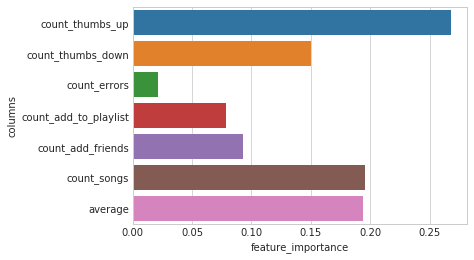

In [60]:

feature_importances = crossValModel3.bestModel.stages[2].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': input_cols})
sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)

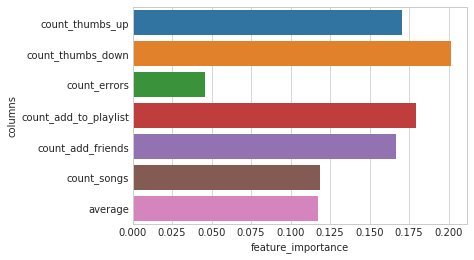

In [61]:
feature_importances = crossValModel2.bestModel.stages[2].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': input_cols})
sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)

We can see that count of thumbs up is the most important feature in predicting user churn in the gradient boosting tree classifier, while for the random forest classifier we can see that the count of thumbs down is the most important feature with some other important features include count of thumbs up, count of songs added to playlist, and friends added by users.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Conclusion

We can summarize what we had done in this project in the following steps:

- Load the dataset into Apache Spark and clean it of any missing userIds and sessionsIds.
- Calculate features that help us model our solution.
- Feed the newly calculated features into 3 machine learning algorithms. Find the best hyperparameters and the model amongst these.
- Calculate the features that are most important in predicting user churn.

It was difficult to decide which features to use in building our model; therefore, i calculated the features i thought would be the most useful in predicting churn.
